In [ ]:
import random
from collections import namedtuple, deque
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Subset
import gymnasium
import torchvision.models as models
import cv2
from PIL import Image, ImageDraw
import os
from sklearn.metrics import confusion_matrix
import copy 

In [ ]:
BATCH_SIZE = 32
LEARNING_RATE = 1e-4 #скорость обучения CNN
NUM_CLASSES = 10
IMG_SIZE = 128
NUM_IMAGES = 50000
MAX_SUBSET_SIZE = 1000 #количество изображений в выборке
CNN_EPOCHS = 1

EPS_START = 0.9#стартовое значение epsilon для e-greedy стратегии
EPS_END = 0.05#конечное значение
EPS_DECAY = 200 #скорость изменения epsilon
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.version.cuda) 
print(torch.backends.cudnn.is_available()) 
print(torch.__version__)  



12.1
True
2.5.1+cu121


In [3]:
class DataSet():
    def __init__(self):# 1. Параметры генератора
        self.CELL_COUNT_RANGE = (1, 10)  # Количество клеток на изображение (минимум, максимум)
        self.CELL_SIZE_RANGE = (5, 15)  # Диаметр клеток (минимум, максимум)
        self.CELL_COLOR_RANGE = ((100, 0, 0), (255, 100, 100))  # Цвет клеток (минимум, максимум по BGR)
        self.BACKGROUND_COLOR = (247, 131, 243)  # Розовый фон
        self.OVERLAP_PROBABILITY = 0.1  # Вероятность перекрытия клетки с другой

    def random_color(self, color_range):
        """Генерирует случайный цвет в заданном диапазоне."""
        return tuple(random.randint(color_range[0][i], color_range[1][i]) for i in range(3))

    def generate_blood_cell_image(self):
        """Генерирует одно изображение с клетками крови."""
        image = Image.new("RGB", (IMG_SIZE, IMG_SIZE), self.BACKGROUND_COLOR)
        draw = ImageDraw.Draw(image)
        cell_count = random.randint(self.CELL_COUNT_RANGE[0], self.CELL_COUNT_RANGE[1])
        cells = []  # Список координат и размеров клеток, чтобы отслеживать перекрытия

        for _ in range(cell_count):
            cell_size = random.randint(self.CELL_SIZE_RANGE[0], self.CELL_SIZE_RANGE[1])

            # Попробуем найти позицию для клетки, чтобы избежать перекрытия (если OVERLAP_PROBABILITY низкая)
            max_attempts = 100
            for attempt in range(max_attempts):
                x = random.randint(cell_size, IMG_SIZE - cell_size)
                y = random.randint(cell_size, IMG_SIZE - cell_size)

                # Проверяем, перекрывается ли новая клетка с существующими
                overlap = False
                if random.random() > self.OVERLAP_PROBABILITY: # Проверяем, нужно ли вообще проверять перекрытие
                    for existing_x, existing_y, existing_size in cells:
                        distance = np.sqrt((x - existing_x)**2 + (y - existing_y)**2)
                        if distance < (cell_size + existing_size) * 0.7:  # Уменьшил коэфф. для допущения небольшого перекрытия
                            overlap = True
                            break

                if not overlap:
                    break # Нашли подходящую позицию

            if overlap and attempt == max_attempts-1 :
                #Если не нашли хорошую позицию, то игнорируем данную клетку
                continue


            cell_color = self.random_color(self.CELL_COLOR_RANGE)
            draw.ellipse((x - cell_size, y - cell_size, x + cell_size, y + cell_size), fill=cell_color)
            cells.append((x, y, cell_size))

        return np.array(image), cell_count

    def generate_dataset(self,num_images, output_dir="blood_cell_dataset"):
        """Генерирует набор данных изображений и меток."""
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        images = []
        labels = []

        for i in range(num_images):
            image, cell_count = self.generate_blood_cell_image()
            images.append(image)
            labels.append(cell_count) #label-1 to make 0 index

            # Сохранение изображений (опционально)
            #image_path = os.path.join(output_dir, f"image_{i}.png")
           # cv2.imwrite(image_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))  # Convert to BGR for OpenCV

        return images, labels


In [4]:
def get_dataloader(subset, shuffle=True,batch_sz=BATCH_SIZE):
    return DataLoader(subset, batch_size=batch_sz, shuffle=shuffle)


In [5]:
class Flatten(nn.Module):
    def forward(self, batch):
        return batch.reshape(batch.size(0), -1)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.cv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.cv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.cv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
       # self.dropout = nn.Dropout(0.25) # Dropout
        self.flatten = Flatten()
        self.fc1 = nn.Linear(128 * (IMG_SIZE//8) * (IMG_SIZE//8), 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = F.relu(self.bn1(self.cv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.cv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.cv3(x)))
        x = self.pool(x)
        x = self.flatten(x)
       # x = self.dropout(x)  # Применяем Dropout перед полносвязными слоями
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.fc2(x)
        return x

In [6]:
class BloodCellDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        #self.images = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images]  # Преобразуем в градации серого
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        #image = np.expand_dims(image, axis=0)  # Добавляем канал (1, H, W)

        if self.transform:
            image = self.transform(image)

        image = torch.tensor(image, dtype=torch.float32).permute(2,0,1) # Convert to float and permute
        return image, torch.tensor(label, dtype=torch.long)


In [7]:
class DataPreloading():
    def __init__(self, num_samples=NUM_IMAGES):
        self.dataset_generator = DataSet()
        images, labels = self.dataset_generator.generate_dataset(num_samples)

        self.dataset = BloodCellDataset(images, labels)
    def get_train_data(self):
        return self.dataset

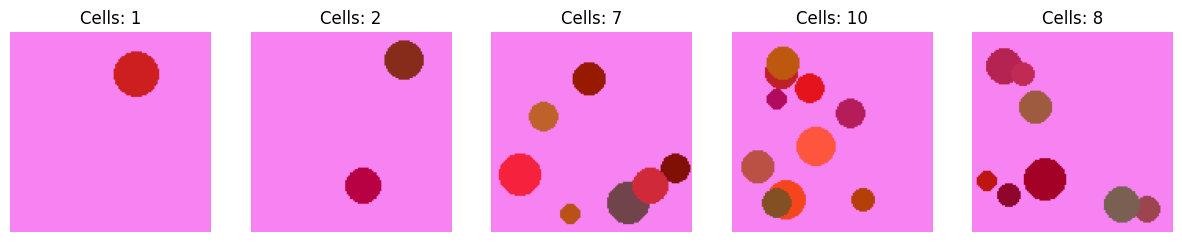

In [8]:
train_data = DataPreloading(num_samples=100).get_train_data()
# 5. Визуализация
import matplotlib.pyplot as plt

def visualize_data(images, labels, num_samples=5):
    """Визуализирует несколько случайных изображений из набора данных."""
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        index = random.randint(0, len(images) - 1)
        axes[i].imshow(images[index])
        axes[i].set_title(f"Cells: {labels[index]}")
        axes[i].axis('off')
    plt.show()

visualize_data(train_data.images, train_data.labels)

In [9]:
class Actor(nn.Module):
    def __init__(self, input_size, num_actions):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=-1)
        return x

class Critic(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [10]:
class DataSelectionEnv(gymnasium.Env):
    def __init__(self):
        super(DataSelectionEnv, self).__init__()
        self.train_data = DataPreloading(num_samples=NUM_IMAGES).get_train_data()
        #self.model = SimpleCNN().to(DEVICE) 
        self.model = models.resnet18(weights=None)
        # Получаем количество входных признаков для последнего слоя ResNet18
        num_ftrs = self.model.fc.in_features

        # Создаем новый последний слой с нужным количеством выходов
        self.model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
        print(f"Последний слой ResNet18 заменен на nn.Linear({num_ftrs}, {NUM_CLASSES})")
        self.model = self.model.to(DEVICE)
        print(f"---CNN модель будет обучаться на устройстве {DEVICE}")
        self.criterion = nn.CrossEntropyLoss()
        self.indexes = self.class_select()
        self.optim = optim.Adam(self.model.parameters(), lr=LEARNING_RATE,weight_decay=1e-5) #пробовал добавлять weight_decay

        # Пространство действий: вероятности выбора изображений для каждого класса
        self.action_space = gymnasium.spaces.Box(low=0, high=1, shape=(NUM_CLASSES,), dtype=np.float32)
        self.observation_space = gymnasium.spaces.Box(low=0, high=1, shape=(NUM_CLASSES,), dtype=np.float32)

        #validation set
        self.validation_indices = random.sample(range(len(self.train_data)), int(0.2 * len(self.train_data)))
        self.validation_subset = Subset(self.train_data, self.validation_indices)
        self.validation_dataloader = get_dataloader(self.validation_subset, shuffle=False,batch_sz=16)

    def class_select(self):#возвращаем словарь из индексов принадлежащим классам
        ls = {i: [] for i in range(NUM_CLASSES)} #создали пустой словарь на 10 классов

        for x, (image, label) in enumerate(self.train_data): #unpack both
            label_value = label.item()-1 #значения меток начинаются с 1, а индексация с 0
            ls[label_value].append(x) #индекс каждого изображения из train_data положили в нужный класс в зависимости от метки

        return ls

    def sample(self, action):#action - тензор распределения процентов изображений от каждого класса в выборке
        action = np.clip(action, 0, 1) #clip the action
        action = action / np.sum(action) #renormalize to ensure sum = 1
        index = []

        for i in range(NUM_CLASSES):
            num_img = int(action[i] * MAX_SUBSET_SIZE) #определили количество изображений для i-го класса в выборке из batch_size изображений
            indexes = np.random.choice(self.indexes[i], num_img, replace=True) #рандомно выбираем вычисленное количество изображений из изображений нужного класса, возвращаем их индексы
            index.extend(indexes)#добавляем найденные индексы в выборку

        return Subset(self.train_data, index)#состовляем subset

    def step(self, action,weights):
        # в этой функции мы создаем выборку на основе action и проверяем, насколько улучшилось или ухудшилось предсказание сети
        #action = np.clip(action + np.random.uniform(-0.05, 0.05, size=action.shape), 0, 1)
        train_subset = self.sample(action) #subset - выбранное случайное подмножество из 32 элементов на основе распределения action
        train_dataloader = get_dataloader(train_subset) #создали dataloader, выдающий этот batch из 32 элементов
        #prev_acc, _ = self.evaluate(test_dataloader) #вычиляем текущую точность модели на тестовой выборке
        self.train_model(train_dataloader, epochs=CNN_EPOCHS) #тренируем модель на тренировчной выборке
        _, err_per_cl = self.evaluate(self.validation_dataloader)  # Теперь возвращается точность по классам
        
        reward = np.sum([(1- err_per_cl[i])*weights[i] for i in range(NUM_CLASSES)])
        #reward = new_acc - self.last_acc #Предыдущая награда

        return reward, err_per_cl

    def train_model(self, dataloader, epochs=1):
        # на вход приходит dataloader выдающий batch изображений и ответов к ним
        self.model.train()#Необходимо переводить в train
        for epoch in range(epochs):
            for images, labels in dataloader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                
                self.optim.zero_grad() #обновили optimizer
                output = self.model(images) #получили тензор(batch_size, NUM_CLASSES) с распределением вероятностей для каждого изображения
                
                loss = self.criterion(output, labels-1) #вычислили ошибку с помощью CrossEntropyLoss\
                print("loss = ", loss)
                loss.backward()
                self.optim.step()



    def evaluate(self, dataloader):
        self.model.eval()  # Переводим модель в оценочный режим
        correct = 0
        total = 0
        ls = torch.zeros(NUM_CLASSES, dtype=torch.int64, device=DEVICE)
        ers = torch.zeros(NUM_CLASSES, dtype=torch.int64, device=DEVICE)

        with torch.no_grad():
            for images, labels in dataloader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                output = self.model(images)  # Получили тензор(batch_size,NUM_CLASSES)
                predicted = torch.argmax(output, dim=1)+1  # Получили тезор(batch_size)
                correct += (predicted == labels).sum().item()  # Нашли количество правильных ответов
                total += labels.size(0) 

                # Обновляем ls и ers
                for i in range(NUM_CLASSES):
                    ls[i] += (labels == i+1).sum()
                    ers[i] += ((labels == i+1) & (predicted != labels)).sum()

        # Вычисляем error_per_class, обрабатывая деление на ноль
        error_per_class = [(ers[i].float() / ls[i].float()).item() if ls[i] > 0 else 0 for i in range(NUM_CLASSES)]
        accuracy = (correct / total) if total > 0 else 0  # Находим точность на данной выборке
        print("accuracy = ", accuracy)
        return accuracy, error_per_class


In [11]:
Transition = namedtuple('Transition',('state','action','next_state','reward'))

class replay_memory(object):
    def __init__(self,capacity):
        self.memory = deque([],maxlen=capacity)
    def push(self,*args):
        self.memory.append(Transition(*args))
    def sample(self,batch_size):
        return random.sample(self.memory,batch_size)
    def __len__(self):
        return len(self.memory)  

In [12]:
import torch.profiler as profiler
prof = profiler.profile(
    schedule=profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
    on_trace_ready=torch.profiler.tensorboard_trace_handler('./log'),
    record_shapes=True,
    profile_memory=True,
    with_stack=True
)

In [13]:
def calculate_class_values(error_per_class):#функция для вычисления весов классов по ошибке на них
    """Вычисляет ценность классов на основе ошибок."""
    class_values = [min(1.0 / (1 - error + 1e-6), 10) for error in error_per_class]  # Избегаем деления на 0
    return class_values

In [14]:
def actor_critic(env, actor, critic, episodes=10, max_steps=100, gamma=0.99,
                 lr_actor=1e-4, lr_critic=1e-4, 
                 entropy_coeff=0.01,           # Коэффициент для энтропийного бонуса
                 patience=30,                  # Терпение для ранней остановки
                 eval_freq=20):                # Частота оценки на тестовой выборке
    
    optimizer_actor = optim.AdamW(actor.parameters(), lr=lr_actor)
    optimizer_critic = optim.AdamW(critic.parameters(), lr=lr_critic)

    actor.to(DEVICE)
    critic.to(DEVICE)
    memory = replay_memory(10000) # Буфер воспроизведения
    save_path = "last_model_checkpoint.pth"
    save_best_path = "best_model_checkpoint.pth"

    # --- Создание согласованного тестового набора данных ---
    # Используем валидационный набор из среды, если он там создается и фиксирован
    # Или создаем здесь один раз
    if hasattr(env, 'validation_dataloader') and env.validation_dataloader is not None:
         test_dataloader = env.validation_dataloader
         print("Используется validation_dataloader из среды для оценки.")
    else:
        print("Создание отдельного тестового набора данных для оценки...")
        test_dataset_full = DataPreloading(num_samples=max(NUM_IMAGES // 5, 2000)).get_train_data() # Берем часть данных для теста
        test_indices = random.sample(range(len(test_dataset_full)), int(0.2 * len(test_dataset_full))) # 20% от этого
        test_subset = Subset(test_dataset_full, test_indices)
        test_dataloader = get_dataloader(test_subset,shuffle=False,batch_sz=16)
        print(f"Размер тестового набора: {len(test_subset)} изображений.")
        # Убедимся, что среда использует свой валидационный набор для вычисления ошибки по классам
        if not hasattr(env, 'validation_dataloader') or env.validation_dataloader is None:
             print("ВНИМАНИЕ: У среды нет фиксированного validation_dataloader. Ошибка по классам может вычисляться на разных данных!")


    steps_done = 0
    best_test_accuracy = -1.0  # Используем тестовую точность для ранней остановки
    no_improvement_steps = 0
    best_model_state = None

    # --- Инициализация начального состояния ---
    print("Инициализация начального состояния (оценка на валидационном наборе)...")
    env.model.eval() # Переводим CNN в режим оценки
    _, initial_errors = env.evaluate(env.validation_dataloader) # Используем валидационный набор среды
    initial_state = np.array(initial_errors, dtype=np.float32)
    print(f"Начальное состояние (ошибки по классам): {initial_state}")


    for episode in range(episodes):
        # state = np.ones(NUM_CLASSES, dtype=np.float32) / NUM_CLASSES # Старая инициализация
        state = initial_state if episode == 0 else next_state # Используем вычисленное начальное или из пред. шага
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE) # Добавляем batch dimension

        for step in range(max_steps):
            steps_done += 1

            # --- Выбор действия ---
            epsilon = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
            action_source = ""
            if random.random() < epsilon:
                # Исследование: Используем распределение Дирихле для генерации случайных пропорций
                action = np.random.dirichlet(np.ones(NUM_CLASSES)).astype(np.float32)
                action_source = "случайное (Dirichlet)"
            else:
                # Эксплуатация: Используем выход Actor'а
                actor.eval() # Переводим Actor в режим оценки для выбора действия
                with torch.no_grad():
                    # state_tensor уже имеет batch dimension [1, NUM_CLASSES]
                    action_probabilities = actor(state_tensor)
                actor.train() # Возвращаем Actor в режим обучения
                action = action_probabilities.squeeze(0).cpu().numpy() # Убираем batch dimension
                action_source = "агент"

            # Обеспечим, чтобы сумма была 1 (из-за возможных ошибок округления)
            action = np.clip(action, 0, 1)
            action = action / np.sum(action)

            print(f"Эпизод: {episode+1}/{episodes}, Шаг: {step+1}/{max_steps}, Epsilon: {epsilon:.4f}")
            print(f"Текущее состояние (ошибки): {state}") # Можно раскомментировать для детального логгирования
            print(f"Действие ({action_source}): {action}")

            # --- Взаимодействие со средой ---
            # Среда обучает CNN и возвращает reward и новое состояние (ошибки по классам)
            weights = calculate_class_values(state) # Веса на основе ТЕКУЩЕГО состояния
            print(f"Веса для классов: {weights}")
            # Передаем действие (numpy array) и веса в среду
            reward, next_state_errors = env.step(action, weights)
            next_state = np.array(next_state_errors, dtype=np.float32) # Преобразуем в numpy array

            print(f"Награда: {reward:.4f}, Новое состояние (ошибки): {next_state}")

            # --- Сохранение перехода ---
            reward_tensor = torch.tensor([reward], dtype=torch.float32).to(DEVICE)
            action_tensor = torch.FloatTensor(action).to(DEVICE) # Без batch dimension
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(DEVICE) # Добавляем batch dimension

            # state_tensor был [1, NUM_CLASSES], убираем batch dimension перед сохранением
            memory.push(state_tensor.squeeze(0), action_tensor, next_state_tensor.squeeze(0), reward_tensor)

            state = next_state
            state_tensor = next_state_tensor # Обновляем state_tensor для следующего шага

            # --- Обучение Агента (если достаточно данных в буфере) ---
            if len(memory) >= BATCH_SIZE: # Начинаем обучение только при полном батче
                transitions = memory.sample(BATCH_SIZE)
                batch = Transition(*zip(*transitions))

                # Преобразуем батч в тензоры
                # state_batch и next_state_batch будут [BATCH_SIZE, NUM_CLASSES]
                state_batch = torch.stack(batch.state).to(DEVICE)
                action_batch = torch.stack(batch.action).to(DEVICE) # [BATCH_SIZE, NUM_CLASSES]
                reward_batch = torch.cat(batch.reward).to(DEVICE)   # [BATCH_SIZE]
                next_state_batch = torch.stack(batch.next_state).to(DEVICE)

                # --- Обучение Critic ---
                critic.train() # Убедимся, что Critic в режиме обучения
                # Текущее значение состояния V(s)
                current_values = critic(state_batch).squeeze() # [BATCH_SIZE]
                # Значение следующего состояния V(s')
                with torch.no_grad(): # Не обновляем Critic на основе будущих значений
                    next_values = critic(next_state_batch).squeeze() # [BATCH_SIZE]

                # Вычисляем TD target: R + gamma * V(s')
                td_target = reward_batch + gamma * next_values
                # Вычисляем Advantage: A(s,a) = TD target - V(s)
                advantage = td_target - current_values

                # Лосс Critic: минимизируем ошибку предсказания (MSE или Huber loss)
                loss_critic = F.mse_loss(current_values, td_target.detach()) # Отсоединяем target
                # loss_critic = F.smooth_l1_loss(current_values, td_target.detach()) # Huber loss - более робастный

                optimizer_critic.zero_grad()
                loss_critic.backward()
                optimizer_critic.step()

                # --- Обучение Actor ---
                actor.train() # Убедимся, что Actor в режиме обучения
                # Получаем логиты или log_softmax от Actor'а для текущих состояний
                action_log_probs_all = F.log_softmax(actor(state_batch), dim=1) # [BATCH_SIZE, NUM_CLASSES]

                # --- ИСПРАВЛЕННЫЙ ЛОСС ACTOR'а ---
                # Вместо gather с argmax, используем advantage для взвешивания log_probs
                # Мы хотим увеличить log_probs для действий, которые привели к высокому advantage
                # Умножаем каждый log_prob на advantage (отсоединенный)
                # advantage.detach().unsqueeze(1) преобразует [BATCH_SIZE] в [BATCH_SIZE, 1] для broadcast'а
                loss_actor_policy = -(action_log_probs_all * advantage.detach().unsqueeze(1)).mean()

                # --- Энтропийный бонус ---
                # Поощряем исследование, добавляя энтропию к лоссу (со знаком минус, т.к. минимизируем)
                action_probs_all = F.softmax(actor(state_batch), dim=1)
                entropy = -torch.sum(action_probs_all * torch.log(action_probs_all + 1e-6), dim=1).mean()
                loss_actor = loss_actor_policy - entropy_coeff * entropy

                optimizer_actor.zero_grad()
                loss_actor.backward()
                # torch.nn.utils.clip_grad_norm_(actor.parameters(), max_norm=1.0) # Опционально: клиппинг градиентов
                optimizer_actor.step()

                # print(f"    Loss Critic: {loss_critic.item():.4f}, Loss Actor (Policy): {loss_actor_policy.item():.4f}, Entropy: {entropy.item():.4f}") # Детальный лог лоссов

            # --- Оценка и Ранняя Остановка ---
            if steps_done % eval_freq == 0:
                print("-" * 30)
                print(f"Оценка на шаге {steps_done} (Эпизод {episode+1}, Шаг {step+1})")
                env.model.eval() # Переводим CNN в режим оценки
                current_test_accuracy, _ = env.evaluate(test_dataloader) # Оцениваем на ТЕСТОВОМ наборе
                env.model.train() # Возвращаем CNN в режим обучения для среды
                print(f"Текущая Точность на Тесте: {current_test_accuracy:.4f}")

                if current_test_accuracy > best_test_accuracy:
                    best_test_accuracy = current_test_accuracy
                    no_improvement_steps = 0
                    print(f"*** Новая лучшая точность на тесте: {best_test_accuracy:.4f}. Сохранение модели... ***")
                    # Сохраняем состояние всех моделей и оптимизаторов
                    best_model_state = {
                        'actor_state_dict': copy.deepcopy(actor.state_dict()),
                        'critic_state_dict': copy.deepcopy(critic.state_dict()),
                        'actor_optimizer_state_dict': copy.deepcopy(optimizer_actor.state_dict()),
                        'critic_optimizer_state_dict': copy.deepcopy(optimizer_critic.state_dict()),
                        'cnn_state_dict': copy.deepcopy(env.model.state_dict()), # Сохраняем и CNN
                        'steps_done': steps_done,
                        'best_test_accuracy': best_test_accuracy
                    }
                    try:
                            torch.save(best_model_state, save_best_path) # Сохраняем лучший на диск
                            print(f"*** ЛУЧШАЯ модель успешно сохранена в {save_best_path} ***")
                    except Exception as e:
                        print(f"ОШИБКА при сохранении ЛУЧШЕЙ модели на шаге {steps_done}: {e}")
                else:
                    no_improvement_steps += 1
                    print(f"Точность не улучшилась. Шагов без улучшения: {no_improvement_steps}/{patience}")

                if no_improvement_steps >= patience:
                    print(f"Ранняя остановка! Нет улучшений на тестовой выборке в течение {patience} * {eval_freq} шагов.")
                    # Загружаем лучшую найденную модель
                    if best_model_state is not None:
                        print("Восстановление лучшей модели...")
                        actor.load_state_dict(best_model_state['actor_state_dict'])
                        critic.load_state_dict(best_model_state['critic_state_dict'])
                        optimizer_actor.load_state_dict(best_model_state['actor_optimizer_state_dict'])
                        optimizer_critic.load_state_dict(best_model_state['critic_optimizer_state_dict'])
                        env.model.load_state_dict(best_model_state['cnn_state_dict'])
                        steps_done = best_model_state['steps_done'] # Можно восстановить и шаги
                        print(f"Лучшая модель восстановлена (Точность: {best_model_state['best_test_accuracy']:.4f})")
                    else:
                         print("Не найдено лучшей модели для восстановления.")
                    return # Завершаем обучение полностью

                print("-" * 30)

        # В конце эпизода можно добавить дополнительную логику, если нужно
        print(f"Конец Эпизода {episode+1}")

    # Если ранняя остановка не сработала, загружаем лучшую модель после всех эпизодов
    print("\nОбучение завершено по окончанию всех эпизодов.")

    # +++ ДОБАВЛЕНО: СОХРАНЕНИЕ ПОСЛЕДНЕГО СОСТОЯНИЯ МОДЕЛЕЙ +++
    print(f"Сохранение последнего состояния моделей в файл: {save_path}")
    last_model_state = {
        'cnn_state_dict': env.model.state_dict(), # Берем текущее состояние
        'actor_state_dict': actor.state_dict(),
        'critic_state_dict': critic.state_dict(),
        'actor_optimizer_state_dict': optimizer_actor.state_dict(), # Сохраним и оптимизаторы
        'critic_optimizer_state_dict': optimizer_critic.state_dict(),
        'steps_done': steps_done, # Сохраним шаг, на котором закончили
        # Можно сохранить и последнюю точность на тесте, если хотите
        # 'last_test_accuracy': current_test_accuracy if 'current_test_accuracy' in locals() else -1.0
    }
    try:
        torch.save(last_model_state, save_path)
        print(f"*** Последнее состояние моделей успешно сохранено в {save_path} ***")
    except Exception as e:
        print(f"ОШИБКА при сохранении последней модели: {e}")
    # +++ КОНЕЦ ДОБАВЛЕННОГО БЛОКА +++

    print(f"\n--- Обучение завершено ---")
    return last_model_state # Возвращаем словарь с последним состоянием

# --- Пример Запуска ---
# env = DataSelectionEnv()
# actor = Actor(NUM_CLASSES, NUM_CLASSES)
# critic = Critic(NUM_CLASSES)
#
# # Визуализация начальных данных (если нужно)
# # visualize_data(env.train_data.images, env.train_data.labels)
#
# actor_critic(env, actor, critic,
#              episodes=20,          # Больше эпизодов
#              max_steps=50,         # Меньше шагов в эпизоде? (Подбирать)
#              lr_actor=1e-4,        # Низкая скорость обучения
#              lr_critic=1e-4,       # Низкая скорость обучения
#              entropy_coeff=0.01,   # Коэффициент энтропии
#              eval_freq=20,         # Частота оценки
#              patience=10)          # Терпение (в единицах eval_freq)
#
# print("Training complete!")
#
# # Финальная оценка на тестовом наборе с использованием ЛУЧШЕЙ модели (уже загружена)
# # Создаем DataLoader для теста еще раз, если он не был сохранен
# test_dataset_final = DataPreloading(num_samples=max(NUM_IMAGES // 5, 2000)).get_train_data()
# test_indices_final = random.sample(range(len(test_dataset_final)), int(0.2 * len(test_dataset_final)))
# test_subset_final = Subset(test_dataset_final, test_indices_final)
# test_dataloader_final = get_dataloader(test_subset_final, shuffle=False)
#
# print("Финальная оценка лучшей модели на тестовом наборе:")
# env.model.eval() # Убедимся, что модель в режиме оценки
# final_accuracy, final_error_per_class = env.evaluate(test_dataloader_final)
#
# print(f"Финальная Точность на Тесте: {final_accuracy:.4f}")
# print("Финальная Ошибка по классам:", final_error_per_class)

Последний слой ResNet18 заменен на nn.Linear(512, 10)
---CNN модель будет обучаться на устройстве cuda


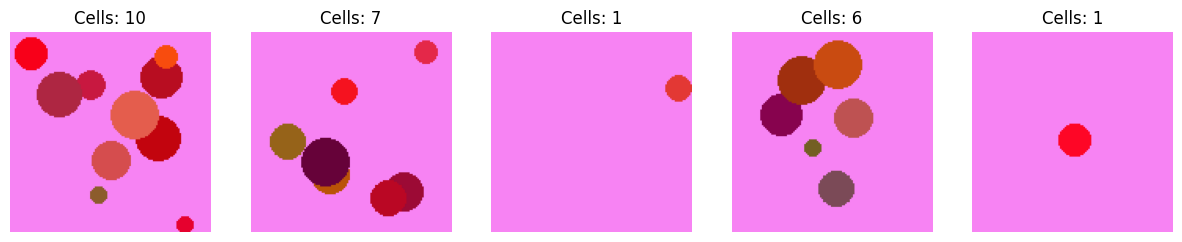

Используется validation_dataloader из среды для оценки.
Инициализация начального состояния (оценка на валидационном наборе)...
accuracy =  0.0987
Начальное состояние (ошибки по классам): [1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
Эпизод: 1/10, Шаг: 1/100, Epsilon: 0.8958
Текущее состояние (ошибки): [1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
Действие (агент): [0.11637308 0.08807877 0.08854654 0.10078763 0.09970511 0.09404115
 0.11913537 0.09105982 0.08206312 0.12020941]
Веса для классов: [10, 10, 10, 10, 10, np.float32(0.99999905), 10, 10, 10, 10]
loss =  tensor(2.4669, device='cuda:0', grad_fn=<NllLossBackward0>)
loss =  tensor(2.1796, device='cuda:0', grad_fn=<NllLossBackward0>)
loss =  tensor(2.1014, device='cuda:0', grad_fn=<NllLossBackward0>)
loss =  tensor(2.0949, device='cuda:0', grad_fn=<NllLossBackward0>)
loss =  tensor(2.0795, device='cuda:0', grad_fn=<NllLossBackward0>)
loss =  tensor(1.7404, device='cuda:0', grad_fn=<NllLossBackward0>)
loss =  tensor(2.0251, device='cuda:0', grad_fn=<NllLossBackw

In [15]:
env = DataSelectionEnv()
actor = Actor(NUM_CLASSES, NUM_CLASSES)
critic = Critic(NUM_CLASSES)


visualize_data(env.train_data.images, env.train_data.labels)

actor_critic(env, actor, critic, episodes=10)
print("Training complete!")